In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %%capture
!pip install simpletransformers

### runs

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import os
import json
import math
import random
import pandas as pd
from random import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, fbeta_score, precision_recall_fscore_support

In [ ]:
# Custom classification report with F0.5 score

from sklearn.metrics import precision_score, recall_score, fbeta_score, precision_recall_fscore_support
from sklearn.utils import _unique
from sklearn.metrics import _classification
from sklearn.utils import multiclass
import warnings
import numpy as np
from numbers import Integral, Real
from sklearn.utils._param_validation import (
    Hidden,
    Interval,
    Options,
    StrOptions,
    validate_params,
)

@validate_params(
    {
        "y_true": ["array-like", "sparse matrix"],
        "y_pred": ["array-like", "sparse matrix"],
        "labels": ["array-like", None],
        "target_names": ["array-like", None],
        "sample_weight": ["array-like", None],
        "digits": [Interval(Integral, 0, None, closed="left")],
        "output_dict": ["boolean"],
        "zero_division": [
            Options(Real, {0.0, 1.0}),
            "nan",
            StrOptions({"warn"}),
        ],
    },
    prefer_skip_nested_validation=True,
)
def classification_report_f0_5(
    y_true,
    y_pred,
    *,
    labels=None,
    target_names=None,
    sample_weight=None,
    digits=2,
    output_dict=False,
    zero_division="warn",
):
    """Build a text report showing the main classification metrics.

    Read more in the :ref:`User Guide <classification_report>`.

    Parameters
    ----------
    y_true : 1d array-like, or label indicator array / sparse matrix
        Ground truth (correct) target values.

    y_pred : 1d array-like, or label indicator array / sparse matrix
        Estimated targets as returned by a classifier.

    labels : array-like of shape (n_labels,), default=None
        Optional list of label indices to include in the report.

    target_names : array-like of shape (n_labels,), default=None
        Optional display names matching the labels (same order).

    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.

    digits : int, default=2
        Number of digits for formatting output floating point values.
        When ``output_dict`` is ``True``, this will be ignored and the
        returned values will not be rounded.

    output_dict : bool, default=False
        If True, return output as dict.

        .. versionadded:: 0.20

    zero_division : {"warn", 0.0, 1.0, np.nan}, default="warn"
        Sets the value to return when there is a zero division. If set to
        "warn", this acts as 0, but warnings are also raised.

        .. versionadded:: 1.3
           `np.nan` option was added.

    Returns
    -------
    report : str or dict
        Text summary of the precision, recall, F1 score for each class.
        Dictionary returned if output_dict is True. Dictionary has the
        following structure::

            {'label 1': {'precision':0.5,
                         'recall':1.0,
                         'f1-score':0.67,
                         'support':1},
             'label 2': { ... },
              ...
            }

        The reported averages include macro average (averaging the unweighted
        mean per label), weighted average (averaging the support-weighted mean
        per label), and sample average (only for multilabel classification).
        Micro average (averaging the total true positives, false negatives and
        false positives) is only shown for multi-label or multi-class
        with a subset of classes, because it corresponds to accuracy
        otherwise and would be the same for all metrics.
        See also :func:`precision_recall_fscore_support` for more details
        on averages.

        Note that in binary classification, recall of the positive class
        is also known as "sensitivity"; recall of the negative class is
        "specificity".

    See Also
    --------
    precision_recall_fscore_support: Compute precision, recall, F-measure and
        support for each class.
    confusion_matrix: Compute confusion matrix to evaluate the accuracy of a
        classification.
    multilabel_confusion_matrix: Compute a confusion matrix for each class or sample.

    Examples
    --------
    >>> from sklearn.metrics import classification_report
    >>> y_true = [0, 1, 2, 2, 2]
    >>> y_pred = [0, 0, 2, 2, 1]
    >>> target_names = ['class 0', 'class 1', 'class 2']
    >>> print(classification_report(y_true, y_pred, target_names=target_names))
                  precision    recall  f1-score   support
    <BLANKLINE>
         class 0       0.50      1.00      0.67         1
         class 1       0.00      0.00      0.00         1
         class 2       1.00      0.67      0.80         3
    <BLANKLINE>
        accuracy                           0.60         5
       macro avg       0.50      0.56      0.49         5
    weighted avg       0.70      0.60      0.61         5
    <BLANKLINE>
    >>> y_pred = [1, 1, 0]
    >>> y_true = [1, 1, 1]
    >>> print(classification_report(y_true, y_pred, labels=[1, 2, 3]))
                  precision    recall  f1-score   support
    <BLANKLINE>
               1       1.00      0.67      0.80         3
               2       0.00      0.00      0.00         0
               3       0.00      0.00      0.00         0
    <BLANKLINE>
       micro avg       1.00      0.67      0.80         3
       macro avg       0.33      0.22      0.27         3
    weighted avg       1.00      0.67      0.80         3
    <BLANKLINE>
    """

    y_true, y_pred = _unique.attach_unique(y_true, y_pred)
    y_type, y_true, y_pred = _classification._check_targets(y_true, y_pred)

    if labels is None:
        labels = multiclass.unique_labels(y_true, y_pred)
        labels_given = False
    else:
        labels = np.asarray(labels)
        labels_given = True

    # labelled micro average
    micro_is_accuracy = (y_type == "multiclass" or y_type == "binary") and (
        not labels_given or (set(labels) >= set(multiclass.unique_labels(y_true, y_pred)))
    )

    if target_names is not None and len(labels) != len(target_names):
        if labels_given:
            warnings.warn(
                "labels size, {0}, does not match size of target_names, {1}".format(
                    len(labels), len(target_names)
                )
            )
        else:
            raise ValueError(
                "Number of classes, {0}, does not match size of "
                "target_names, {1}. Try specifying the labels "
                "parameter".format(len(labels), len(target_names))
            )
    if target_names is None:
        target_names = ["%s" % l for l in labels]

    headers = ["precision", "recall", "f0.5-score", "support"]
    # compute per-class results without averaging
    p, r, f1, s = precision_recall_fscore_support(
        y_true,
        y_pred,
        labels=labels,
        beta=0.5,
        average=None,
        sample_weight=sample_weight,
        zero_division=zero_division,
    )
    rows = zip(target_names, p, r, f1, s)

    if y_type.startswith("multilabel"):
        average_options = ("micro", "macro", "weighted", "samples")
    else:
        average_options = ("micro", "macro", "weighted")

    if output_dict:
        report_dict = {label[0]: label[1:] for label in rows}
        for label, scores in report_dict.items():
            report_dict[label] = dict(zip(headers, [float(i) for i in scores]))
    else:
        longest_last_line_heading = "weighted avg"
        name_width = max(len(cn) for cn in target_names)
        width = max(name_width, len(longest_last_line_heading), digits)
        head_fmt = "{:>{width}s} " + " {:>9}" * len(headers)
        report = head_fmt.format("", *headers, width=width)
        report += "\n\n"
        row_fmt = "{:>{width}s} " + " {:>9.{digits}f}" * 3 + " {:>9}\n"
        for row in rows:
            report += row_fmt.format(*row, width=width, digits=digits)
        report += "\n"

    # compute all applicable averages
    for average in average_options:
        if average.startswith("micro") and micro_is_accuracy:
            line_heading = "accuracy"
        else:
            line_heading = average + " avg"

        # compute averages with specified averaging method
        avg_p, avg_r, avg_f1, _ = precision_recall_fscore_support(
            y_true,
            y_pred,
            labels=labels,
            beta=0.5,
            average=average,
            sample_weight=sample_weight,
            zero_division=zero_division,
        )
        avg = [avg_p, avg_r, avg_f1, np.sum(s)]

        if output_dict:
            report_dict[line_heading] = dict(zip(headers, [float(i) for i in avg]))
        else:
            if line_heading == "accuracy":
                row_fmt_accuracy = (
                    "{:>{width}s} "
                    + " {:>9.{digits}}" * 2
                    + " {:>9.{digits}f}"
                    + " {:>9}\n"
                )
                report += row_fmt_accuracy.format(
                    line_heading, "", "", *avg[2:], width=width, digits=digits
                )
            else:
                report += row_fmt.format(line_heading, *avg, width=width, digits=digits)

    if output_dict:
        if "accuracy" in report_dict.keys():
            report_dict["accuracy"] = report_dict["accuracy"]["precision"]
        return report_dict
    else:
        return report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

# I used 'provide_confusion_matrix' , 'calculate_precision_recall_f1score' , 'evaluation_model' functions from previous term
def provide_confusion_matrix(GoldLabel, PredictLabel, label_set):
    """
    use `sklearn.metric confusion_matrix` to create confusion matrix of model predict.
    and `sklearn.metric ConfusionMatrixDisplay` to display created confusion matrix.

    Parameters
    ----------
    GoldLabel : list
        list of all Gold labels
    PredictLabel : list
        list of all Prediction labels
    label_set : list
        list of all classes

    Returns
    -------
        Confusion matrix
    """
    print(label_set)
    cf_matrix = confusion_matrix(GoldLabel, PredictLabel) # create a confusion matrix with gold and predicts
    print(cf_matrix) # print confusion_matrix as text
    display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=label_set) # create graphical confusion_matrix
    fig, ax = plt.subplots()# figsize=(15,15)) # create bigger plot because there is many classes in this task
    display.plot(ax =ax) # show confusion_matrix
    plt.xticks(rotation=90) # rotate X label of plot 90 degree
    plt.show() # show confusion matrix
    return cf_matrix # return confusion_matrix (maybe useful later)

def calculate_precision_recall_f05score(GoldLabel, PredictLabel, label_set): # function get gold and predict and set of labels
    """
    use `sklearn.metric classification_report` to get report of model predict.

    Parameters
    ----------
    GoldLabel : list
        list of all Gold labels
    PredictLabel : list
        list of all Prediction labels
    label_set : list
        list of all classes

    Returns
    -------
        Classification report
    """
    print(label_set)
    report = classification_report_f0_5(GoldLabel, PredictLabel, digits = 3, target_names=label_set) # calculate report
    print(report) # print report
    return report # return report (maybe useful later)


def fine_tune_eval(GoldLabel, PredictLabel, target_names): # get gold and predict
    """
    Evaluation models by call `calculate_precision_recall_f1score` and `provide_confusion_matrix` functions.

    Parameters
    ----------
    data :
        Train or test or dev dataset (after extracting fetures)
    PredictLabel : list
        list of all Prediction labels

    Returns
    -------
        Classification report and Confusion matrix
    """
    # set(list(preds_hp_2_1)+test_data_gold)
    label_set = target_names
    # label_set = sorted(set(list(PredictLabel) + GoldLabel)) # find unique lables in gold

    print(label_set)

    print('precision_recall_f1-score')
    report = calculate_precision_recall_f05score(GoldLabel, PredictLabel, label_set) # calculate_precision_recall_f1score

    print('Confusion matrix')
    cf_matrix = provide_confusion_matrix(GoldLabel, PredictLabel, label_set) # provide_confusion_matrix

    return report, cf_matrix # return report and cf_matrix


In [ ]:
def fine_tune_model(model_path, train_data, save_dir, model_name, seed_val):
  """
  Fine-tune a pre-trained model using the Simple Transformers library.
  Args:
    model_path (str): Path to the pre-trained model.
	train_data (pd.DataFrame): Training data in a pandas DataFrame.
	save_dir (str): Directory to save the fine-tuned model.
	model_name (str): Name of the model.
	seed_val (int): Seed value for reproducibility.
  Returns:
    model (ClassificationModel): The fine-tuned model.
  """
  print(f"seed: {seed_val}")
  # Define model arguments
  model_args = ClassificationArgs(#eval_batch_size=64,
                                  # evaluate_during_training=True,
                                  save_eval_checkpoints=False,
                                  output_dir=f'{save_dir}/fine_tuned_{model_name}_model',
                                  save_model_every_epoch=False,
                                  save_steps=-1,
                                  manual_seed=seed_val,
                                  num_train_epochs=5,
                                  # evaluate_during_training_steps=2621,
                                  overwrite_output_dir=True,
                                  labels_list=['G', 'PREP', 'DET','SVA']
                                  )

  # model_args.num_train_epochs = 10

  model = ClassificationModel('roberta', model_path, args=model_args, num_labels=4, use_cuda=True)
  # model = ClassificationModel('roberta',
  #                             model_path,#'/content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e1_v20_l4',
  #                             args=model_args,
  #                             num_labels=4
  #                             )

  model.train_model(train_data)

  return model
  # pass

In [ ]:
def predict_model(model_path, test_data):
  """
  Predict labels for the test data using a fine-tuned model.
  Args:
	model_path (str): Path to the fine-tuned model.
	test_data (pd.DataFrame): Test data in a pandas DataFrame.
  Returns:
    predictions (list): List of predicted labels.
  """
  model = ClassificationModel('roberta', model_path)
  predictions, raw_outputs = model.predict(test_data)

  return predictions


In [ ]:
def save_model_preds(test_data, model_preds, save_path, model_name):
  """
  Save test data with model predictions to a CSV file.
  Args:
	test_data (pd.DataFrame): Test data in a pandas DataFrame.
	model_preds (list): List of predicted labels.
	save_path (str): Path to save the output CSV file.
	model_name (str): Name of the model.
  Returns:
	out_data (pd.DataFrame): DataFrame containing test data and predictions.
  """
  out_data = test_data.copy()
  out_data['prediction']=model_preds
  out_data.to_csv(os.path.join(save_path, f"outfile_{model_name}.csv"), index=False)
  return out_data

In [ ]:
def generate_random_number():
  """
  Generate a random integer between 1 and 1000.
  Returns:
	random_integer (int): A random integer between 1 and 1000.
  """
  random_integer = random.randint(1, 1000)
  print(f"random number: {random_integer}")
  return random_integer

In [ ]:
main_path = "/content/drive/MyDrive/VU Thesis/Code/fine_tune"
data_path = "/content/drive/MyDrive/VU Thesis/Code/fine_tune/data"
save_path = "/content/drive/MyDrive/VU Thesis/Code/fine_tune/models"
outfile_path = "/content/drive/MyDrive/VU Thesis/Code/fine_tune/outfiles"

In [ ]:
print("loading data...")

print("loading train_data.csv")
train_df =pd.read_csv(os.path.join(data_path, "train_data.csv"))

print("loading dev_data.csv")
dev_df =pd.read_csv(os.path.join(data_path, "dev_data.csv"))

print("loading test_data.csv")
test_df =pd.read_csv(os.path.join(data_path, "test_data.csv"))

print("loading data compelete.")

loading data...
loading train_data.csv
loading dev_data.csv
loading test_data.csv
loading data compelete.


In [ ]:
train_df.head()

,text,labels,UID
0,The libraries that have worked with Christina ...,G,sentential_negation_npi_scope
1,The person joke around.,SVA,irregular_plural_subject_verb_agreement_2
2,I was rather thirsty and hungry after the show...,PREP,Preposition_Unnecessary
3,Most students go to these restaurant.,DET,determiner_noun_agreement_2
4,The report about the Great Lakes are astoundin...,SVA,distractor_agreement_relational_noun


In [ ]:
test_data = list(test_df.text)#.to_list()
gold_labels = list(test_df.labels)#.to_list()
print(len(test_data), len(gold_labels))

6988 6988


In [ ]:
test_data[:20]

['Those customers examine those commentaries.',
 'Even Carlos will often happen to die.',
 'Ordinary lessons attended by students from different levels of ability.',
 'Margaret has said Craig discusses himself.',
 'Julia skated around that popular cafe.',
 'Modern technology is used all the time at home, at school or working.',
 'Many senators scan this black newspaper articles.',
 'I thought it was a good idea to tell to Pat because we could use it to look for exams, and then we could pass all of them.',
 "Robert couldn't embarrass that scared people.",
 "It's himself who Brad talked to.",
 "Lori isn't messing up that tooth.",
 'Guy bored that troubled man.',
 'I can play games, listen to music, and I can do my course work in the computer.',
 'People were sitting down.',
 "Homer wouldn't go to these banks.",
 'Thomas has hidden those small tooth.',
 'Deanna explores these oasis.',
 'Caroline was observing that standing man.',
 'This analysis has appeared to alarm Steve.',
 "Lori hasn'

### models

In [ ]:
rand_seed = generate_random_number()

random number: 464


In [ ]:
### !!! IF YOU WANT TO REPLICATE EXPERIMENT RUN THIS CELL !!! ###
# rand seed = 464

#### E1

In [ ]:
model_path_e1 = "/content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e1_v20_l4"
model_name_e1 = "v20_l4_e1"
model_e1 = fine_tune_model(model_path_e1, train_df, save_path, model_name_e1, rand_seed)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e1_v20_l4 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


seed: 464


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


['DET', 'G', 'PREP', 'SVA']
precision_recall_f1-score
['DET', 'G', 'PREP', 'SVA']
              precision    recall f0.5-score   support

         DET      0.983     0.992     0.985      1508
           G      0.901     0.793     0.877      3494
        PREP      0.561     0.832     0.600       879
         SVA      0.879     0.864     0.876      1107

    accuracy                          0.852      6988
   macro avg      0.831     0.870     0.834      6988
weighted avg      0.872     0.852     0.865      6988

Confusion matrix
['DET', 'G', 'PREP', 'SVA']
[[1496   12    0    0]
 [  22 2769  572  131]
 [   0  147  731    1]
 [   4  146    0  957]]


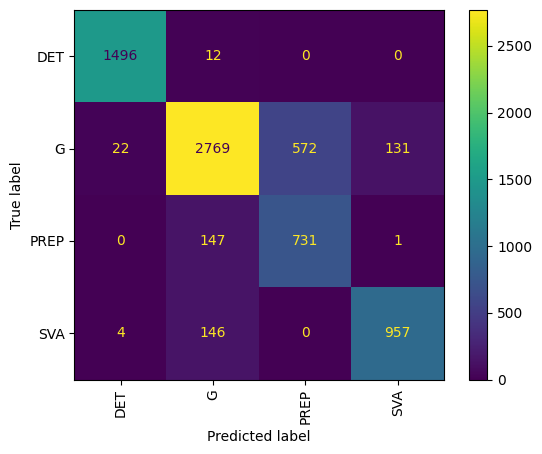

In [ ]:
model_e1_path = '/content/drive/MyDrive/VU Thesis/Code/fine_tune/models/fine_tuned_v20_l4_e1_model'

preds_e1 = predict_model(model_e1_path, test_data)
# report = classification_report_f0_5(test_df.labels.tolist(), preds) #, output_dict=True)
target_names = ['DET', 'G', 'PREP','SVA']
# target_names = ['G', 'PREP', 'DET','SVA']
report_e1, cf_matrix_e1 = fine_tune_eval(gold_labels, preds_e1, target_names)
df_e1 = save_model_preds(test_df, preds_e1, outfile_path, 'v20_l4_e1')

#### E2

In [ ]:
model_path_e2 = "/content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e2_v20_l4"
model_name_e2 = "v20_l4_e2"
model_e2 = fine_tune_model(model_path_e2, train_df, save_path, model_name_e2, rand_seed)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e2_v20_l4 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


seed: 464


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


['DET', 'G', 'PREP', 'SVA']
precision_recall_f1-score
['DET', 'G', 'PREP', 'SVA']
              precision    recall f0.5-score   support

         DET      0.988     1.000     0.990      1508
           G      0.908     0.821     0.889      3494
        PREP      0.556     0.778     0.590       879
         SVA      0.940     0.912     0.935      1107

    accuracy                          0.869      6988
   macro avg      0.848     0.878     0.851      6988
weighted avg      0.886     0.869     0.881      6988

Confusion matrix
['DET', 'G', 'PREP', 'SVA']
[[1508    0    0    0]
 [  18 2868  546   62]
 [   1  192  684    2]
 [   0   97    0 1010]]


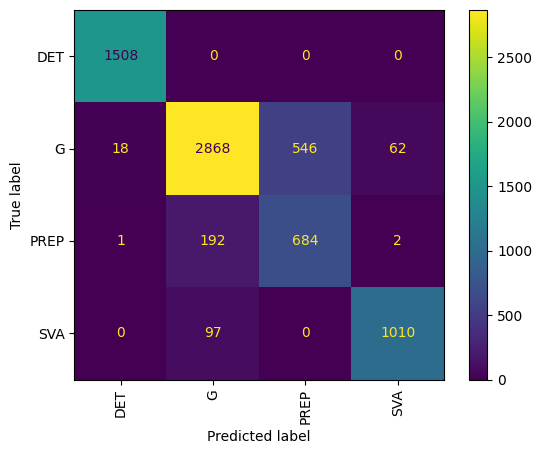

In [ ]:
model_e2_path = '/content/drive/MyDrive/VU Thesis/Code/fine_tune/models/fine_tuned_v20_l4_e2_model'

preds_e2 = predict_model(model_e2_path, test_data)
# report = classification_report_f0_5(test_df.labels.tolist(), preds) #, output_dict=True)
target_names = ['DET', 'G', 'PREP','SVA']
# target_names = ['G', 'PREP', 'DET','SVA']
report_e2, cf_matrix_e2 = fine_tune_eval(gold_labels, preds_e2, target_names)
df_e2 = save_model_preds(test_df, preds_e2, outfile_path, 'v20_l4_e2')

#### E3

In [ ]:
model_path_e3 = "/content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e3_v20_l4"
model_name_e3 = "v20_l4_e3"
model_e3 = fine_tune_model(model_path_e3, train_df, save_path, model_name_e3, rand_seed)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e3_v20_l4 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


seed: 464


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


['DET', 'G', 'PREP', 'SVA']
precision_recall_f1-score
['DET', 'G', 'PREP', 'SVA']
              precision    recall f0.5-score   support

         DET      0.991     1.000     0.993      1508
           G      0.916     0.826     0.896      3494
        PREP      0.553     0.783     0.587       879
         SVA      0.962     0.931     0.956      1107

    accuracy                          0.875      6988
   macro avg      0.855     0.885     0.858      6988
weighted avg      0.894     0.875     0.888      6988

Confusion matrix
['DET', 'G', 'PREP', 'SVA']
[[1508    0    0    0]
 [  12 2885  557   40]
 [   0  190  688    1]
 [   1   75    0 1031]]


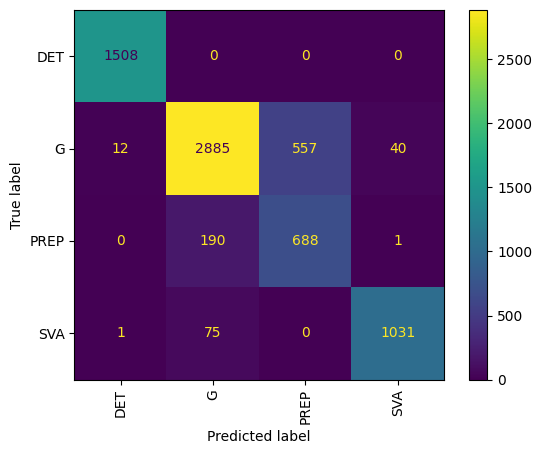

In [ ]:
model_e3_path = '/content/drive/MyDrive/VU Thesis/Code/fine_tune/models/fine_tuned_v20_l4_e3_model'

preds_e3 = predict_model(model_e3_path, test_data)
# report = classification_report_f0_5(test_df.labels.tolist(), preds) #, output_dict=True)
target_names = ['DET', 'G', 'PREP','SVA']
# target_names = ['G', 'PREP', 'DET','SVA']
report_e3, cf_matrix_e3 = fine_tune_eval(gold_labels, preds_e3, target_names)
df_e3 = save_model_preds(test_df, preds_e3, outfile_path, 'v20_l4_e3')

#### E4

In [ ]:
model_path_e4 = "/content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e4_v20_l4"
model_name_e4 = "v20_l4_e4"
model_e4 = fine_tune_model(model_path_e4, train_df, save_path, model_name_e4, rand_seed)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e4_v20_l4 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


seed: 464


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


['DET', 'G', 'PREP', 'SVA']
precision_recall_f1-score
['DET', 'G', 'PREP', 'SVA']
              precision    recall f0.5-score   support

         DET      0.991     1.000     0.993      1508
           G      0.922     0.824     0.900      3494
        PREP      0.553     0.782     0.587       879
         SVA      0.955     0.948     0.954      1107

    accuracy                          0.876      6988
   macro avg      0.855     0.888     0.858      6988
weighted avg      0.895     0.876     0.889      6988

Confusion matrix
['DET', 'G', 'PREP', 'SVA']
[[1508    0    0    0]
 [  12 2880  556   46]
 [   1  188  687    3]
 [   1   57    0 1049]]


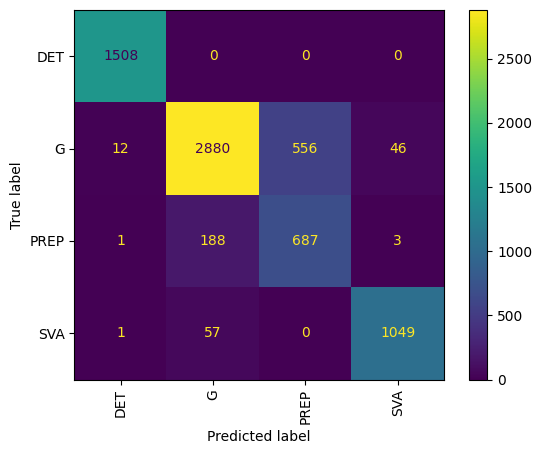

In [ ]:
model_e4_path = '/content/drive/MyDrive/VU Thesis/Code/fine_tune/models/fine_tuned_v20_l4_e4_model'

preds_e4 = predict_model(model_e4_path, test_data)
# report = classification_report_f0_5(test_df.labels.tolist(), preds) #, output_dict=True)
target_names = ['DET', 'G', 'PREP','SVA']
# target_names = ['G', 'PREP', 'DET','SVA']
report_e4, cf_matrix_e4 = fine_tune_eval(gold_labels, preds_e4, target_names)
df_e4 = save_model_preds(test_df, preds_e4, outfile_path, 'v20_l4_e4')

#### E5

In [ ]:
model_path_e5 = "/content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e5_v20_l4"
model_name_e5 = "v20_l4_e5"
model_e5 = fine_tune_model(model_path_e5, train_df, save_path, model_name_e5, rand_seed)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e5_v20_l4 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


seed: 464


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


['DET', 'G', 'PREP', 'SVA']
precision_recall_f1-score
['DET', 'G', 'PREP', 'SVA']
              precision    recall f0.5-score   support

         DET      0.993     1.000     0.995      1508
           G      0.921     0.826     0.900      3494
        PREP      0.556     0.785     0.591       879
         SVA      0.956     0.947     0.954      1107

    accuracy                          0.878      6988
   macro avg      0.857     0.889     0.860      6988
weighted avg      0.896     0.878     0.890      6988

Confusion matrix
['DET', 'G', 'PREP', 'SVA']
[[1508    0    0    0]
 [  10 2886  550   48]
 [   0  189  690    0]
 [   0   59    0 1048]]


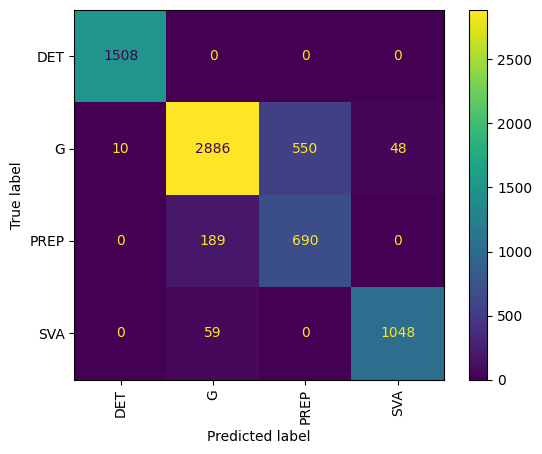

In [ ]:
model_e5_path = '/content/drive/MyDrive/VU Thesis/Code/fine_tune/models/fine_tuned_v20_l4_e5_model'

preds_e5 = predict_model(model_e5_path, test_data)
# report = classification_report_f0_5(test_df.labels.tolist(), preds) #, output_dict=True)
target_names = ['DET', 'G', 'PREP','SVA']
# target_names = ['G', 'PREP', 'DET','SVA']
report_e5, cf_matrix_e5 = fine_tune_eval(gold_labels, preds_e5, target_names)
df_e5 = save_model_preds(test_df, preds_e5, outfile_path, 'v20_l4_e5')

#### E6

In [ ]:
model_path_e6 = "/content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e6_v20_l4"
model_name_e6 = "v20_l4_e6"
model_e6 = fine_tune_model(model_path_e6, train_df, save_path, model_name_e6, rand_seed)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e6_v20_l4 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


seed: 464


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


['DET', 'G', 'PREP', 'SVA']
precision_recall_f1-score
['DET', 'G', 'PREP', 'SVA']
              precision    recall f0.5-score   support

         DET      0.995     1.000     0.996      1508
           G      0.920     0.828     0.900      3494
        PREP      0.553     0.776     0.587       879
         SVA      0.960     0.948     0.957      1107

    accuracy                          0.878      6988
   macro avg      0.857     0.888     0.860      6988
weighted avg      0.896     0.878     0.890      6988

Confusion matrix
['DET', 'G', 'PREP', 'SVA']
[[1508    0    0    0]
 [   8 2893  551   42]
 [   0  195  682    2]
 [   0   58    0 1049]]


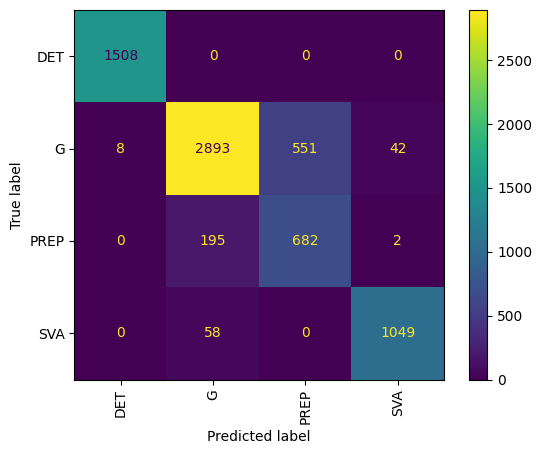

In [ ]:
model_e6_path = '/content/drive/MyDrive/VU Thesis/Code/fine_tune/models/fine_tuned_v20_l4_e6_model'

preds_e6 = predict_model(model_e6_path, test_data)
# report = classification_report_f0_5(test_df.labels.tolist(), preds) #, output_dict=True)
target_names = ['DET', 'G', 'PREP','SVA']
# target_names = ['G', 'PREP', 'DET','SVA']
report_e6, cf_matrix_e6 = fine_tune_eval(gold_labels, preds_e6, target_names)
df_e6 = save_model_preds(test_df, preds_e6, outfile_path, 'v20_l4_e6')

#### E7

In [ ]:
model_path_e7 = "/content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e7_v20_l4"
model_name_e7 = "v20_l4_e7"
model_e7 = fine_tune_model(model_path_e7, train_df, save_path, model_name_e7, rand_seed)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e7_v20_l4 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


seed: 464


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


['DET', 'G', 'PREP', 'SVA']
precision_recall_f1-score
['DET', 'G', 'PREP', 'SVA']
              precision    recall f0.5-score   support

         DET      0.994     1.000     0.995      1508
           G      0.921     0.826     0.900      3494
        PREP      0.549     0.776     0.583       879
         SVA      0.962     0.950     0.960      1107

    accuracy                          0.877      6988
   macro avg      0.856     0.888     0.860      6988
weighted avg      0.896     0.877     0.890      6988

Confusion matrix
['DET', 'G', 'PREP', 'SVA']
[[1508    0    0    0]
 [   7 2886  561   40]
 [   1  195  682    1]
 [   1   54    0 1052]]


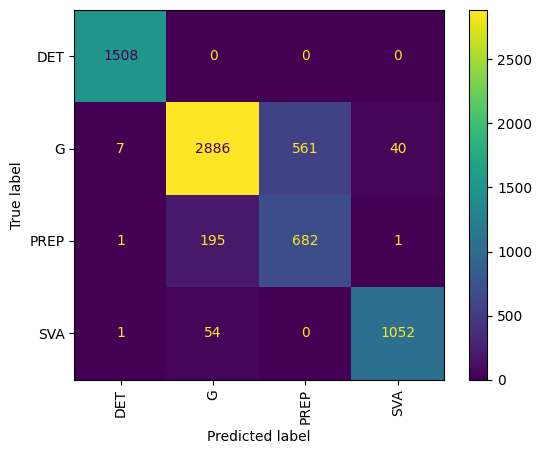

In [ ]:
model_e7_path = '/content/drive/MyDrive/VU Thesis/Code/fine_tune/models/fine_tuned_v20_l4_e7_model'

preds_e7 = predict_model(model_e7_path, test_data)
# report = classification_report_f0_5(test_df.labels.tolist(), preds) #, output_dict=True)
target_names = ['DET', 'G', 'PREP','SVA']
# target_names = ['G', 'PREP', 'DET','SVA']
report_e7, cf_matrix_e7 = fine_tune_eval(gold_labels, preds_e7, target_names)
df_e7 = save_model_preds(test_df, preds_e7, outfile_path, 'v20_l4_e7')

#### E8

In [ ]:
model_path_e8 = "/content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e8_v20_l4"
model_name_e8 = "v20_l4_e8"
model_e8 = fine_tune_model(model_path_e8, train_df, save_path, model_name_e8, rand_seed)

seed: 464


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e8_v20_l4 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


['DET', 'G', 'PREP', 'SVA']
precision_recall_f1-score
['DET', 'G', 'PREP', 'SVA']
              precision    recall f0.5-score   support

         DET      0.995     1.000     0.996      1508
           G      0.920     0.823     0.899      3494
        PREP      0.551     0.793     0.586       879
         SVA      0.960     0.937     0.955      1107

    accuracy                          0.876      6988
   macro avg      0.857     0.888     0.859      6988
weighted avg      0.896     0.876     0.890      6988

Confusion matrix
['DET', 'G', 'PREP', 'SVA']
[[1508    0    0    0]
 [   6 2877  569   42]
 [   1  180  697    1]
 [   0   70    0 1037]]


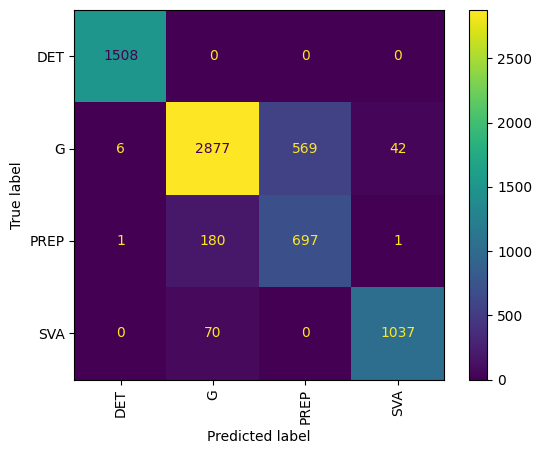

In [ ]:
model_e8_path = '/content/drive/MyDrive/VU Thesis/Code/fine_tune/models/fine_tuned_v20_l4_e8_model'

preds_e8 = predict_model(model_e8_path, test_data)
# report = classification_report_f0_5(test_df.labels.tolist(), preds) #, output_dict=True)
target_names = ['DET', 'G', 'PREP','SVA']
# target_names = ['G', 'PREP', 'DET','SVA']
report_e8, cf_matrix_e8 = fine_tune_eval(gold_labels, preds_e8, target_names)
df_e8 = save_model_preds(test_df, preds_e8, outfile_path, 'v20_l4_e8')

#### E9

In [ ]:
model_path_e9 = "/content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e9_v20_l4"
model_name_e9 = "v20_l4_e9"
model_e9 = fine_tune_model(model_path_e9, train_df, save_path, model_name_e9, rand_seed)

seed: 464


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e9_v20_l4 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


['DET', 'G', 'PREP', 'SVA']
precision_recall_f1-score
['DET', 'G', 'PREP', 'SVA']
              precision    recall f0.5-score   support

         DET      0.993     1.000     0.994      1508
           G      0.922     0.827     0.901      3494
        PREP      0.557     0.787     0.591       879
         SVA      0.960     0.946     0.957      1107

    accuracy                          0.878      6988
   macro avg      0.858     0.890     0.861      6988
weighted avg      0.897     0.878     0.891      6988

Confusion matrix
['DET', 'G', 'PREP', 'SVA']
[[1508    0    0    0]
 [  10 2890  551   43]
 [   0  186  692    1]
 [   1   59    0 1047]]


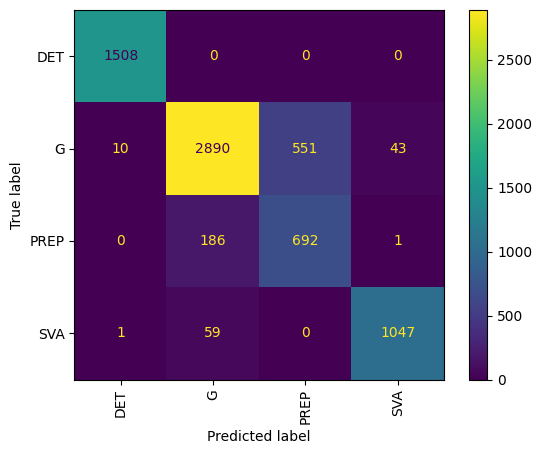

In [ ]:
model_e9_path = '/content/drive/MyDrive/VU Thesis/Code/fine_tune/models/fine_tuned_v20_l4_e9_model'

preds_e9 = predict_model(model_e9_path, test_data)
# report = classification_report_f0_5(test_df.labels.tolist(), preds) #, output_dict=True)
target_names = ['DET', 'G', 'PREP','SVA']
# target_names = ['G', 'PREP', 'DET','SVA']
report_e9, cf_matrix_e9 = fine_tune_eval(gold_labels, preds_e9, target_names)
df_e9 = save_model_preds(test_df, preds_e9, outfile_path, 'v20_l4_e9')

#### E10

In [ ]:
model_path_e10 = "/content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e10_v20_l4"
model_name_e10 = "v20_l4_e10"
model_e10 = fine_tune_model(model_path_e10, train_df, save_path, model_name_e10, rand_seed)

seed: 464


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e10_v20_l4 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


['DET', 'G', 'PREP', 'SVA']
precision_recall_f1-score
['DET', 'G', 'PREP', 'SVA']
              precision    recall f0.5-score   support

         DET      0.995     1.000     0.996      1508
           G      0.917     0.824     0.896      3494
        PREP      0.548     0.782     0.583       879
         SVA      0.960     0.936     0.955      1107

    accuracy                          0.874      6988
   macro avg      0.855     0.885     0.858      6988
weighted avg      0.894     0.874     0.888      6988

Confusion matrix
['DET', 'G', 'PREP', 'SVA']
[[1508    0    0    0]
 [   7 2879  566   42]
 [   0  191  687    1]
 [   0   71    0 1036]]


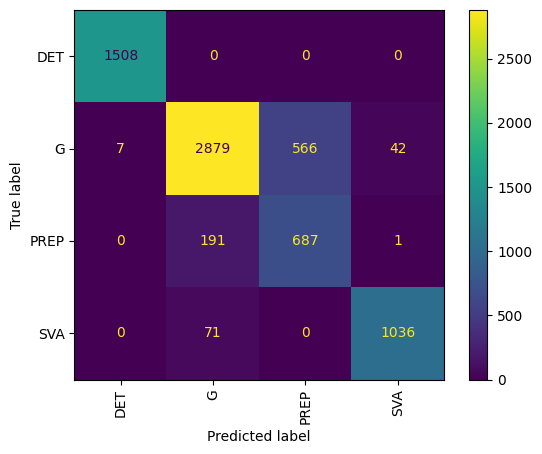

In [ ]:
model_e10_path = '/content/drive/MyDrive/VU Thesis/Code/fine_tune/models/fine_tuned_v20_l4_e10_model'

preds_e10 = predict_model(model_e10_path, test_data)
# report = classification_report_f0_5(test_df.labels.tolist(), preds) #, output_dict=True)
target_names = ['DET', 'G', 'PREP','SVA']
# target_names = ['G', 'PREP', 'DET','SVA']
report_e10, cf_matrix_e10 = fine_tune_eval(gold_labels, preds_e10, target_names)
df_e10 = save_model_preds(test_df, preds_e10, outfile_path, 'v20_l4_e10')

#### O_RoBERTa

In [ ]:
model_path_o = "/content/drive/MyDrive/VU Thesis/Code/baby_models/roberta-base"
model_name_o = "O_RoBERTa"
model_o = fine_tune_model(model_path_o, train_df, save_path, model_name_o, rand_seed)

seed: 464


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/VU Thesis/Code/baby_models/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


['DET', 'G', 'PREP', 'SVA']
precision_recall_f1-score
['DET', 'G', 'PREP', 'SVA']
              precision    recall f0.5-score   support

         DET      0.999     1.000     0.999      1508
           G      0.905     0.939     0.911      3494
        PREP      0.722     0.617     0.698       879
         SVA      0.995     0.992     0.995      1107

    accuracy                          0.920      6988
   macro avg      0.905     0.887     0.901      6988
weighted avg      0.917     0.920     0.917      6988

Confusion matrix
['DET', 'G', 'PREP', 'SVA']
[[1508    0    0    0]
 [   1 3280  209    4]
 [   0  336  542    1]
 [   0    9    0 1098]]


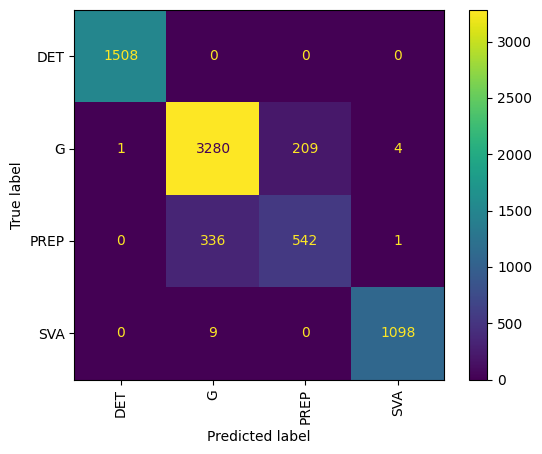

In [ ]:
model_o_path = '/content/drive/MyDrive/VU Thesis/Code/fine_tune/models/fine_tuned_O_RoBERTa_model'

preds_o = predict_model(model_o_path, test_data)
# report = classification_report_f0_5(test_df.labels.tolist(), preds) #, output_dict=True)
target_names = ['DET', 'G', 'PREP','SVA']
# target_names = ['G', 'PREP', 'DET','SVA']
report_o, cf_matrix_o = fine_tune_eval(gold_labels, preds_o, target_names)
df_o = save_model_preds(test_df, preds_o, outfile_path, 'o_RoBERTa')


#### BB_RoBERTa

In [ ]:
model_path_bb = "/content/drive/MyDrive/VU Thesis/Code/baby_models/roberta-base-strict-small-2023"
model_name_bb = "BB_RoBERTa"
model_bb = fine_tune_model(model_path_bb, train_df, save_path, model_name_bb, rand_seed)

seed: 464


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/VU Thesis/Code/baby_models/roberta-base-strict-small-2023 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


['DET', 'G', 'PREP', 'SVA']
precision_recall_f1-score
['DET', 'G', 'PREP', 'SVA']
              precision    recall f0.5-score   support

         DET      0.999     1.000     0.999      1508
           G      0.915     0.845     0.900      3494
        PREP      0.538     0.702     0.565       879
         SVA      0.985     0.986     0.985      1107

    accuracy                          0.883      6988
   macro avg      0.859     0.883     0.862      6988
weighted avg      0.897     0.883     0.893      6988

Confusion matrix
['DET', 'G', 'PREP', 'SVA']
[[1508    0    0    0]
 [   1 2951  529   13]
 [   0  258  617    4]
 [   0   15    0 1092]]


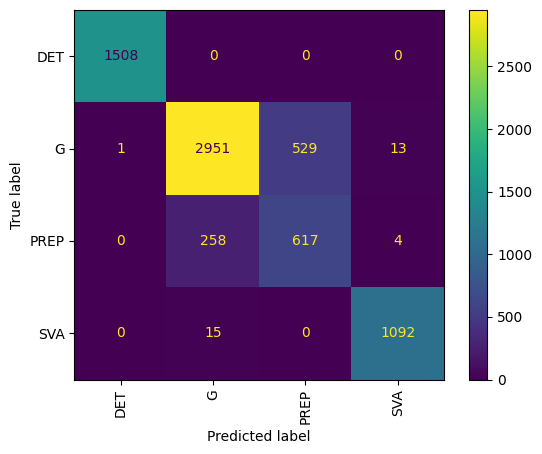

In [ ]:
model_bb_path = '/content/drive/MyDrive/VU Thesis/Code/fine_tune/models/fine_tuned_BB_RoBERTa_model'

preds_bb = predict_model(model_bb_path, test_data)
# report = classification_report_f0_5(test_df.labels.tolist(), preds) #, output_dict=True)
target_names = ['DET', 'G', 'PREP','SVA']
# target_names = ['G', 'PREP', 'DET','SVA']
report_bb, cf_matrix_bb = fine_tune_eval(gold_labels, preds_bb, target_names)
df_bb = save_model_preds(test_df, preds_bb, outfile_path, 'bb_RoBERTa')